In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Exercise 1

In [301]:
def brownian_motion(T, N, D=1):
    return np.random.normal(0, (T / N) ** 0.5, (N, D))
    
def milstein_method(f, L, t0, t1, x0, N):
    
    dt = (t1 - t0) / N
    x = x0
    t = t0
    
    ts = np.linspace(t0, t1, N)
    dWs = brownian_motion(t1 - t0, N)
    
    t_hist = np.array([t])
    x_hist = np.array([x])
    
    for t, dW in zip(ts[1:], dWs):
        
        # Euler-Maruyama term and Milstein correction term
        dx = f(x, t) * dt + L(x, t) * dW
        dx = dx + 0.5 * L(x, t, grad=True) * L(x, t) * (dW ** 2 - dt)
        
        x = x + dx
        
        t_hist = np.concatenate([t_hist, [t]])
        x_hist = np.concatenate([x_hist, [x]])
        
    return t_hist, x_hist, dWs

In [71]:
def black_scholes(c, g):

    def f(x, t, grad=False):
        return - c if grad else - c * x

    def L(x, t, grad=False):
        return g if grad else g * x
    
    return f, L

def exact_black_scholes(x0, c, g, t, W):
    return x0 * np.exp((-c - g ** 2 / 2) * t + g * W)

In [79]:
np.random.seed(0)

c = 1e-1
g = 1e-1
t0 = 0.
t1 = 1e0
x0 = 1e0
N = int(1e2)

f, L = black_scholes(c=c, g=g)

t, x, dWs = milstein_method(f=f, L=L, t0=t0, t1=t1, x0=x0, N=N)

W = np.cumsum(np.concatenate([[0.], dWs[:-1]]))
x_exact = exact_black_scholes(x0=x0, c=c, g=g, t=t, W=W)

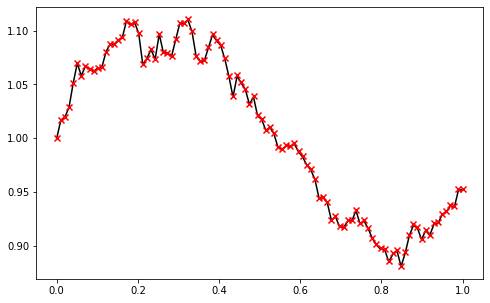

In [80]:
plt.figure(figsize=(8, 5))
plt.scatter(t, x, marker='x', color='red', zorder=3)
plt.plot(t, x_exact, color='k', zorder=1)

# Exercise 2

The SDE used in this exerices is the Benes SDE

$$ dx = \text{tanh}(x) dt + d\beta, $$

where $\beta$ is a standard brownian motion.

In [242]:
def benes():
    
    def f(x, t, x_grad=False, xx_grad=False):
        if x_grad:
            return 1 - np.tanh(x) ** 2
        elif xx_grad:
            return - 2 * np.tanh(x) * (1 - np.tanh(x) ** 2)
        else:
            return np.tanh(x)

    def L(x, t, x_grad=False, xx_grad=False):
        if x_grad or xx_grad:
            return 0.
        else:
            return 1.
    
    def a(x, t):
        return 0

    def b(x, t):
        return (1 - np.tanh(x) ** 2)
    
    return f, L, a, b

def benes_pdf(x, t):
    
    x = x.reshape((-1, 1))
    t = t.reshape((1, -1))
    
    coeff = (2 * np.pi * t) ** -0.5
    prob = coeff * np.cosh(x) * np.exp(- 0.5 * t) * np.exp(- 0.5 * x ** 2 / t)
    
    return prob

In [243]:
def strong_order_15_ito_taylor(f, L, a, b, t0, t1, x0, N):
    
    dt = (t1 - t0) / N
    x = x0
    t = t0
    
    t_hist = np.array([t])
    x_hist = np.array([x])
    dWs = np.array([])
    
    cov = np.array([[dt ** 3 / 3, dt ** 2 / 2],
                    [dt ** 2 / 2,          dt]])
    cov_chol = np.linalg.cholesky(cov)
    
    for i in range(N):
        
        # Jointly sample dW and dz
        djoint = cov_chol @ np.random.normal(0., 1., (2,))
        dz, dW = djoint
        
        # Euler-Maruyama term and higher order correction term
        dx = f(x, t) * dt + L(x, t) * dW
        dx = dx + 0.5 * a(x, t) * dt ** 2 + b(x, t) * dz
        
        t = t + dt
        x = x + dx
        
        t_hist = np.concatenate([t_hist, [t]])
        x_hist = np.concatenate([x_hist, [x]])
        dWs = np.concatenate([dWs, [dW]])
        
    return t_hist, x_hist, dWs

In [244]:
xs = []

for seed in range(5000):

    np.random.seed(seed)

    t0 = 0.
    t1 = 5e0
    x0 = 0.
    N = int(2e2)

    f, L, a, b = benes()

    t, x, dWs = strong_order_15_ito_taylor(f=f, L=L, a=a, b=b, t0=t0, t1=t1, x0=x0, N=N)
    
    xs.append(x)

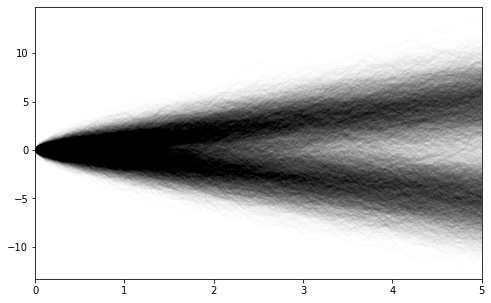

In [245]:
plt.figure(figsize=(8, 5))
plt.plot(t, np.array(xs).T, color='k', alpha=0.01)
plt.xlim([0, 5])
plt.show()

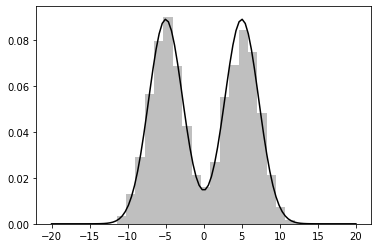

In [246]:
prob = benes_pdf(x=np.linspace(-20, 20, 100), t=np.array(5.))
plt.plot(np.linspace(-20, 20, 100), prob, color='k')
plt.hist(np.array(xs)[:, -1], density=True, bins=20, color='gray', alpha=0.5)
plt.show()

## Scalar weak order 2.0 Ito-Taylor

In [267]:
def three_point_increment(dt):
    theta = np.random.choice([- 3 ** 0.5, 0., 3 ** 0.5], p=[1 / 6, 2 / 3, 1 / 6])
    
    dW = dt ** 0.5 * theta
    dz = 0.5 * dt ** 1.5 * theta
    
    return dW, dz


def gaussian_increment(dt):
    
    dW = np.random.normal(0., dt ** 0.5)
    dz = 0.5 * dW * dt
    
    return dW, dz

In [268]:
def strong_order_20_ito_taylor(f, L, t0, t1, x0, N, noise_sampler):
    
    dt = (t1 - t0) / N
    x = x0
    t = t0
    
    t_hist = np.array([t])
    x_hist = np.array([x])
    dWs = np.array([])
    
    for i in range(N):
        
        dW, dz = noise_sampler(dt)
    
        f_, L_ = f(x, t), L(x, t)
        df_, dL_ = f(x, t, x_grad=True), L(x, t, x_grad=True)
        ddf_, ddL_ = f(x, t, xx_grad=True), L(x, t, xx_grad=True)

        dx = f_ * dt + L_ * dW
        dx = dx + 0.5 * L_ * dL_ * (dW ** 2 - dt)
        dx = dx + df_ * L_ * dz
        dx = dx + 0.5 * (f(x, t) * f(x, t, x_grad=True) + 0.5 * ddf_ * L_ ** 2) * dt ** 2
        dx = dx + (f_ * dL_ + 0.5 * ddL_ * L_ ** 2) * (dW * dt - dz)
        
        t = t + dt
        x = x + dx
        
        t_hist = np.concatenate([t_hist, [t]])
        x_hist = np.concatenate([x_hist, [x]])
        dWs = np.concatenate([dWs, [dW]])
        
    return t_hist, x_hist, dWs

In [269]:
xs = []

for seed in range(5000):

    np.random.seed(seed)

    t0 = 0.
    t1 = 5e0
    x0 = 0.
    N = int(2e2)

    f, L, a, b = benes()

    t, x, dWs = strong_order_20_ito_taylor(f=f, L=L, t0=t0, t1=t1, x0=x0, N=N, noise_sampler=three_point_increment)
    
    xs.append(x)

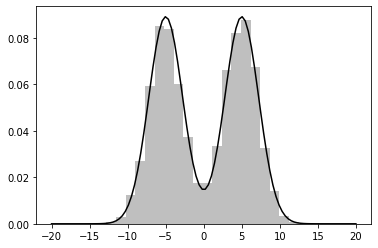

In [270]:
prob = benes_pdf(x=np.linspace(-20, 20, 100), t=np.array(5.))
plt.plot(np.linspace(-20, 20, 100), prob, color='k')
plt.hist(np.array(xs)[:, -1], density=True, bins=20, color='gray', alpha=0.5)
plt.show()

In [271]:
xs = []

for seed in range(5000):

    np.random.seed(seed)

    t0 = 0.
    t1 = 5e0
    x0 = 0.
    N = int(2e2)

    f, L, a, b = benes()

    t, x, dWs = strong_order_20_ito_taylor(f=f, L=L, t0=t0, t1=t1, x0=x0, N=N, noise_sampler=gaussian_increment)
    
    xs.append(x)

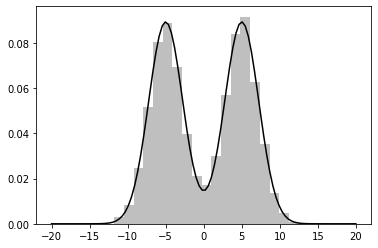

In [272]:
prob = benes_pdf(x=np.linspace(-20, 20, 100), t=np.array(5.))
plt.plot(np.linspace(-20, 20, 100), prob, color='k')
plt.hist(np.array(xs)[:, -1], density=True, bins=20, color='gray', alpha=0.5)
plt.show()

# Exercise 5

The SDE used in this Exercise is

$$ d\mathbf{x} = \mathbf{L}(\mathbf{x}) d\boldsymbol{\beta}. $$

where the diffusion matrix is

$$ \mathbf{L}(\mathbf{x}) = \begin{pmatrix} \cos \alpha \sin x_1 & \cos \alpha \cos x_1 & - \sin \alpha \sin x_2 & - \sin \alpha \cos x_2 \\
                                            \sin \alpha \sin x_1 & \sin \alpha \cos x_1 & \phantom{-}\cos \alpha \sin x_2 & \phantom{-}\cos \alpha \cos x_2 \end{pmatrix}. $$

In [302]:
def toroidal_diffusion(a):
    
    def f(x, t):
        return 0.
    
    def L(x, t):
        
        sina = np.sin(a)
        cosa = np.cos(a)
        
        sinx1 = np.sin(x[0])
        cosx1 = np.cos(x[0])
        sinx2 = np.sin(x[1])
        cosx2 = np.cos(x[1])
        
        L_ = np.array([[cosa * sinx1, cosa * cosx1, - sina * sinx2, - sina * cosx2],
                       [sina * sinx1, sina * cosx1,   cosa * sinx2,   cosa * cosx2]])
        
        return L_
    
    return f, L

In [510]:
def euler_maruyama(f, L, t0, t1, x0, N, D, seed):
    
    np.random.seed(seed)
    
    dt = (t1 - t0) / N
    x = x0
    t = t0
    
    t_hist = np.array([t])
    x_hist = np.array([x])
    dWs = brownian_motion(t1 - t0, N, D=D)
    
    for dW in dWs:
        
        # Euler-Maruyama term
        dx = f(x, t) * dt + L(x, t) @ dW
        
        t = t + dt
        x = x + dx
        
        t_hist = np.concatenate([t_hist, [t]])
        x_hist = np.concatenate([x_hist, [x]])
        
    return t_hist, x_hist, dWs

In [511]:
x0_grid = np.meshgrid(np.linspace(0, 2 * np.pi, 30), np.linspace(0, 2 * np.pi, 30))
x0_grid = np.stack(x0_grid, axis=-1).reshape((-1, 2))

x1 = []

for x0 in x0_grid:
    
    a = 1.
    D = 4
    t0 = 0.
    t1 = 4e0
    N = int((t1 - t0) * 2 ** 4) + 1

    f, L = toroidal_diffusion(a=a)

    t, x, dWs = euler_maruyama(f=f, L=L, t0=t0, t1=t1, x0=x0, N=N, D=D, seed=0)
    
    x1.append(x)
    
x1 = np.array(x1)

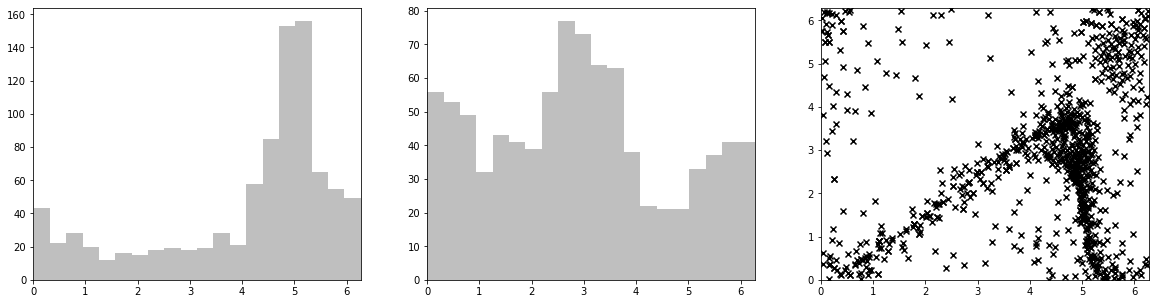

In [513]:
xmod = x1[:, -1, :] % (2 * np.pi)

plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.hist(xmod[:, 0], bins=20, color='gray', alpha=0.5)
plt.xlim([0, 2 * np.pi])

plt.subplot(132)
plt.hist(xmod[:, 1], bins=20, color='gray', alpha=0.5)
plt.xlim([0, 2 * np.pi])

plt.subplot(133)
plt.scatter(xmod[:, 0], xmod[:, 1], marker='x', color='k')
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 2 * np.pi])
plt.show()